In [1]:
# import necessary libraries
import cv2
import numpy as np
import face_recognition
import os
from datetime import datetime
import uuid
import matplotlib.pyplot as plt
%matplotlib inline

### Detecting The Persons to Recognize

In [3]:
image_dir_path = 'train'
images = []
class_names = []
image_files = os.listdir(image_dir_path)

for file in image_files:
    cur_img = cv2.imread(os.path.join(image_dir_path, file))
    images.append(cur_img)
    class_names.append(os.path.splitext(file)[0])

print('Persons: ', class_names)

Persons:  ['Andrew_Garfield', 'Tobey_Maguire', 'Tom_Holland']


### Encoding Faces

In [4]:
def find_encodings(images):
    encode_list = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encode_list.append(encode)
    return encode_list

In [5]:
encode_list_known = find_encodings(images)
print('Face Encoding Complete!')

Face Encoding Complete!


### Necessary Functions

In [6]:
def mark_attendance(attendance_file, name):
    with open(attendance_file, 'r+') as f:
        lines = f.readlines()
        name_list = []
        for line in lines:
            entry = line.split(',')
            name_list.append(entry[0])
        if name not in name_list:
            curr_time = datetime.now()
            curr_time_string = curr_time.strftime('%H:%M:%S')
            f.writelines(f'\n{name},{curr_time_string}')


def draw_focused_rectangle(image, bbox, color, corner_length = 30, corner_thickness = 4, edge_thickness = 1):
    img = image.copy()

    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if (x1+corner_length > x2) or (y1+corner_length > y2):
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
        # top left corner
        cv2.line(img, (x1, y1), (x1+corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y1), (x1, y1+corner_length), color = color, thickness = corner_thickness)
        # top right corner
        cv2.line(img, (x2, y1), (x2-corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y1), (x2, y1+corner_length), color = color, thickness = corner_thickness)
        # bottom left corner
        cv2.line(img, (x1, y2), (x1+corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y2), (x1, y2-corner_length), color = color, thickness = corner_thickness)
        # bottom right corner
        cv2.line(img, (x2, y2), (x2-corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y2), (x2, y2-corner_length), color = color, thickness = corner_thickness)

    return img


def draw_label(image, label, x, y, box_color, font_color, font_face, font_scale):
    img = image.copy()

    text_size = cv2.getTextSize(label, fontFace=font_face, fontScale=font_scale, thickness=1)
    dim, baseline = text_size[0], text_size[1]
    
    cv2.rectangle(img, (x,y), (x + dim[0], y + dim[1] + baseline), box_color, cv2.FILLED);
    cv2.putText(img, label, (x, y + dim[1] + 2), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    return img

### Face Recognition on a Single Image

In [7]:
def face_rec_on_image(img, encode_list_known, class_names, box_color, font_color, font_face, font_scale):
    img_temp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces_img = face_recognition.face_locations(img_temp)
    encodes_img = face_recognition.face_encodings(img_temp, faces_img)

    for encode_face, face_loc in zip(encodes_img, faces_img):
        matches = face_recognition.compare_faces(encode_list_known, encode_face)
        face_dist = face_recognition.face_distance(encode_list_known, encode_face)
        match_index = np.argmin(face_dist)

        if matches[match_index]:
            name = class_names[match_index].upper()
            y1, x2, y2, x1 = face_loc
            img = draw_focused_rectangle(img, (x1, y1, x2, y2), color = box_color)
            img = draw_label(img, name, x1, y2+5, box_color, font_color, font_face, font_scale)

    return img

### Face Recognition on Webcam

In [8]:
def face_rec_on_webcam(encode_list_known, class_names, box_color, font_color, font_face, font_scale):
    cap = cv2.VideoCapture(0)
    cap_downscale = 0.5
    cap_upscale = 1/cap_downscale

    with open('attendance.csv', 'w', encoding='UTF8', newline='') as f:
        f.writelines('Name,Time')
    
    while True:
        success, img = cap.read()
        imgS = cv2.resize(img, (0, 0), None, cap_downscale, cap_downscale)
        imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

        faces_frame = face_recognition.face_locations(imgS)
        encodes_frame = face_recognition.face_encodings(imgS, faces_frame)

        for encode_face, face_loc in zip(encodes_frame, faces_frame):
            matches = face_recognition.compare_faces(encode_list_known, encode_face)
            face_dist = face_recognition.face_distance(encode_list_known, encode_face)
            match_index = np.argmin(face_dist)

            if matches[match_index]:
                name = class_names[match_index].upper()
                y1, x2, y2, x1 = face_loc
                y1, x2, y2, x1 = int(y1*cap_upscale), int(x2*cap_upscale), int(y2*cap_upscale), int(x1*cap_upscale)
                img = draw_focused_rectangle(img, (x1, y1, x2, y2), color = box_color)
                img = draw_label(img, name, x1, y2+5, box_color, font_color, font_face, font_scale)
                mark_attendance('attendance.csv',name)

        cv2.imshow('Video', img)

        if cv2.waitKey(1) & 0xFF == ord('d'):
            break

    cap.release()
    cv2.destroyAllWindows()

### Face Recognition on a Video

In [9]:
def face_rec_on_video(video_path, encode_list_known, class_names, box_color, font_color, font_face, font_scale, save_video = False):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        out = cv2.VideoWriter(f'./output_{uuid.uuid1()}.mp4', fourcc, fps, (width, height))
    
    while True:
        success, img = cap.read()
        if success:
            # img = cv2.resize(img, (0, 0), None, 0.25, 0.25)
            img = face_rec_on_image(img, encode_list_known, class_names, box_color, font_color, font_face, font_scale)
            
            if save_video:
                out.write(img)

            cv2.imshow('Video', img)

            if cv2.waitKey(1) & 0xFF==ord('d'):
                break
        else:
            break
    
    if save_video:
        out.release()
        
    cap.release()
    cv2.destroyAllWindows()

### Let's Recognize

In [10]:
box_color = (0, 252, 124) #BGR
font_color = (0,0,0)
font_face=cv2.FONT_HERSHEY_COMPLEX_SMALL
font_scale=0.9

In [11]:
face_rec_on_webcam(encode_list_known, class_names, box_color, font_color, font_face, font_scale)

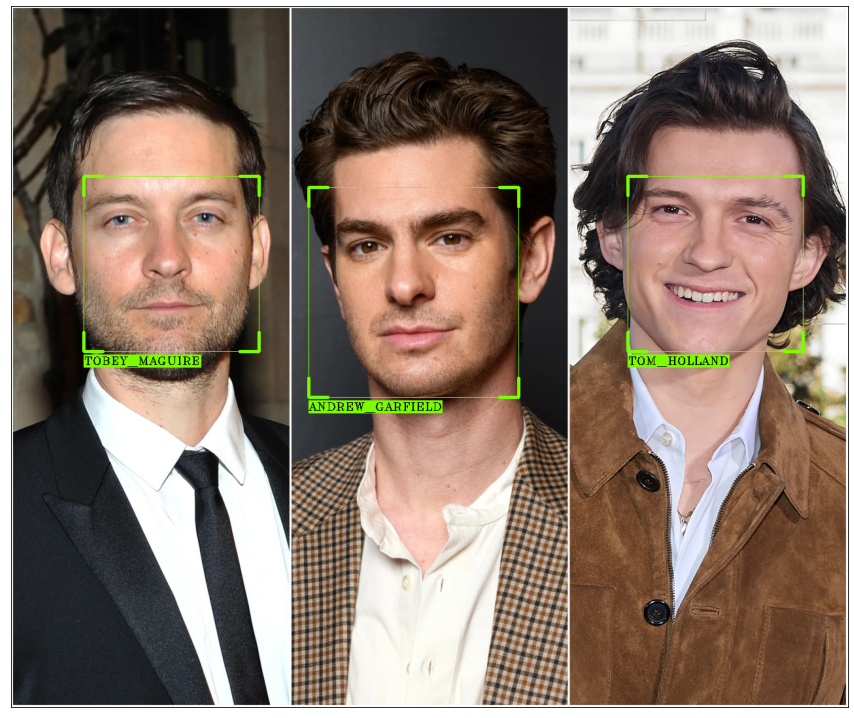

In [27]:
test_image = cv2.imread('test\Tobey_Andrew_Tom.jpg')
# test_image = cv2.resize(test_image, (0,0), None, 0.5, 0.5)
test_image_result = face_rec_on_image(test_image, encode_list_known, class_names, box_color, font_color, font_face, font_scale)
cv2.imwrite(f'output_{uuid.uuid1()}.jpg', test_image_result)

test_image_rbg = cv2.cvtColor(test_image_result, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,15))
plt.imshow(test_image_rbg)
plt.xticks([])
plt.yticks([])
plt.show()

In [16]:
video_path = 'All_SpiderMans_Cut.mp4'
face_rec_on_video(video_path, encode_list_known, class_names, box_color, font_color, font_face, font_scale, save_video=True)